<a href="https://colab.research.google.com/github/andreyshishkov/course_advanced_ml/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Interpretation_homestask_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Интерпретация моделей и калибровка вероятностей

Будем тренироваться на примере задачи классификации оттоковых клиентов

In [1]:
!pip install eli5 -q
!pip install lime -q
!pip install shap -q
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import eli5, lime, shap

from catboost import CatBoostClassifier

Загрузим данные

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/churn_clients.csv")

data.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,KS,128,415,No,Yes,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,False


Обработайте признаки:

* удалите категориальные признаки с больше, чем двумя различными значениями (обратите внимание, что `areacode` - также категориальный признак)

* бинарные признаки перведите в числа: True/Yes -> 1, False/No -> 0

In [4]:
# your code here
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 3333 non-null   object 
 1   accountlength         3333 non-null   int64  
 2   areacode              3333 non-null   int64  
 3   internationalplan     3333 non-null   object 
 4   voicemailplan         3333 non-null   object 
 5   numbervmailmessages   3333 non-null   int64  
 6   totaldayminutes       3333 non-null   float64
 7   totaldaycalls         3333 non-null   float64
 8   totaldaycharge        3333 non-null   float64
 9   totaleveminutes       3333 non-null   float64
 10  totalevecalls         3333 non-null   float64
 11  totalevecharge        3333 non-null   float64
 12  totalnightminutes     3333 non-null   float64
 13  totalnightcalls       3333 non-null   float64
 14  totalnightcharge      3333 non-null   float64
 15  totalintlminutes     

In [6]:
data['churn'] = data['churn'].astype('int')

In [7]:
data.isnull().sum()

state                   0
accountlength           0
areacode                0
internationalplan       0
voicemailplan           0
numbervmailmessages     0
totaldayminutes         0
totaldaycalls           0
totaldaycharge          0
totaleveminutes         0
totalevecalls           0
totalevecharge          0
totalnightminutes       0
totalnightcalls         0
totalnightcharge        0
totalintlminutes        0
totalintlcalls          0
totalintlcharge         0
customerservicecalls    0
churn                   0
dtype: int64

In [11]:
data.nunique()

state                     51
accountlength            212
areacode                   3
internationalplan          2
voicemailplan              2
numbervmailmessages       46
totaldayminutes         1667
totaldaycalls            119
totaldaycharge          1667
totaleveminutes         1611
totalevecalls            123
totalevecharge          1440
totalnightminutes       1591
totalnightcalls          120
totalnightcharge         933
totalintlminutes         162
totalintlcalls            21
totalintlcharge          162
customerservicecalls      10
churn                      2
dtype: int64

In [12]:
data = data.replace({'Yes': 1, 'No': 0})

In [13]:
data.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,KS,128,415,0,1,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,0
1,OH,107,415,0,1,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,0
3,OH,84,408,1,0,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,0
4,OK,75,415,1,0,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,0


In [16]:
data = data.drop(columns=['state', 'areacode',])

## Вопрос

Сколько колонок осталось в таблице data?

In [ ]:
# your code here

In [17]:
len(data.columns)

18

In [18]:
X = data.drop('churn', axis=1)
y = data['churn']

Разбейте данные на тренировочную и тестовую части. Размер тестовой части - 25%, `random_state=42`.

In [19]:
from sklearn.model_selection import train_test_split

# your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Вопрос

Сколько строк в тренировочных данных?

In [20]:
# your code here
X_train.shape

(2499, 17)

Обучите CatBoostClassifier с гиперпараметрами по умолчанию и `random_state=42` на тренировочных данных, сделайте прогноз на тестовых данных и вычислите значение ROC-AUC.

In [21]:
from catboost import CatBoostClassifier

# your code here
ctb = CatBoostClassifier(verbose=0, random_state=42)
ctb.fit(X_train, y_train)

## Вопрос

Чему равно значение ROC-AUC на тестовых данных? Ответ округлите до сотых.

In [22]:
from sklearn.metrics import roc_auc_score

# your code here
predictions = ctb.predict(X_test)
pred_probs = ctb.predict_proba(X_test)[:, 1]

score = roc_auc_score(y_test, pred_probs)

In [25]:
print(round(score, 2))

0.94


Выведите на экран гистограмму важности признаков (стандартную, посчитанную на основе Information Gain)

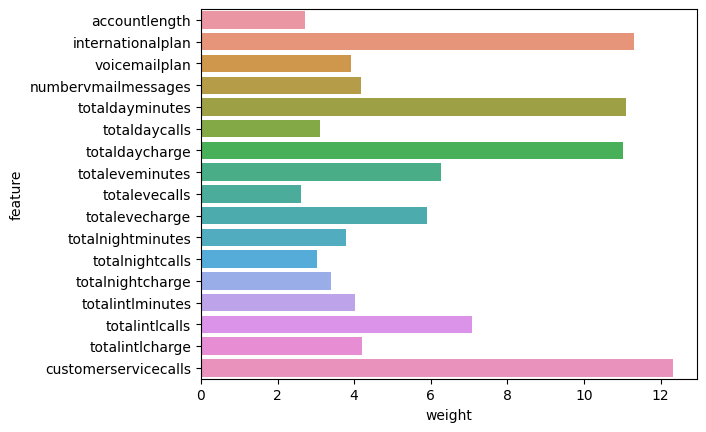

In [26]:
# your code here
model_imps = pd.DataFrame({
    'feature': X.columns,
    'weight': ctb.feature_importances_,
})
sns.barplot(data=model_imps, x='weight', y='feature')
plt.show()

## Вопрос

Какой признак наиболее важен с точки зрения этого подхода?

Постройте гистограмму permutation importance по тренировочным данным

In [27]:
# your code here
perm = eli5.sklearn.PermutationImportance(ctb, random_state=42).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X_train.columns.tolist())

Weight,Feature
0.0599 ± 0.0047,customerservicecalls
0.0545 ± 0.0053,totaldaycharge
0.0519 ± 0.0045,internationalplan
0.0502 ± 0.0065,totaldayminutes
0.0241 ± 0.0031,totalintlcalls
0.0211 ± 0.0012,totaleveminutes
0.0189 ± 0.0014,totalevecharge
0.0142 ± 0.0026,numbervmailmessages
0.0138 ± 0.0032,voicemailplan
0.0130 ± 0.0015,totalintlcharge


## Вопрос

Сколько признаков выделяет метод как наиболее важные? (темно-зеленый цвет на визуализации)

Постройте гистограмму shap values по тестовым данным

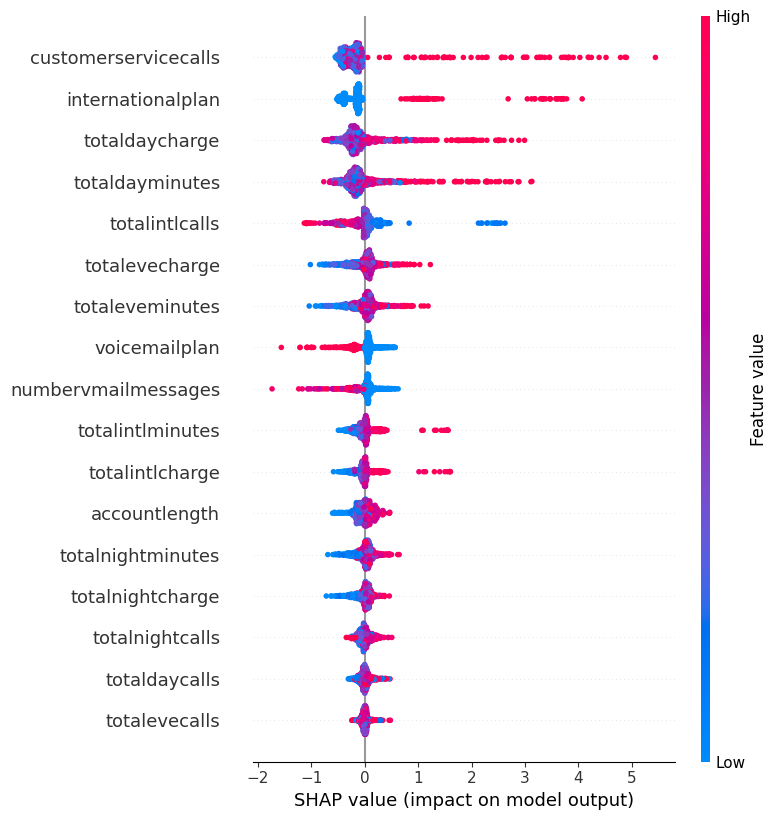

In [29]:
# your code here
shap_explainer = shap.TreeExplainer(ctb)
shap_values = shap_explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

## Вопрос

Какой признак наименее важен с точки зрения подхода SHAP?

Проинтерпретируем теперь индивидуальные прогнозы моделей

Проинтерпретируйте прогноз на тестовом объекте с индексом 5 методами:

* SHAP
* LIME

In [ ]:
# your code here

In [33]:
print(f'Correct answer: {y_test.iloc[5]}')

Correct answer: 0


In [32]:
# LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=X_test.columns.values.tolist(), mode='classification')
lime_explaination = lime_explainer.explain_instance(X_test.values[5], ctb.predict_proba, num_features=5)

lime_explaination.show_in_notebook(show_table=True)

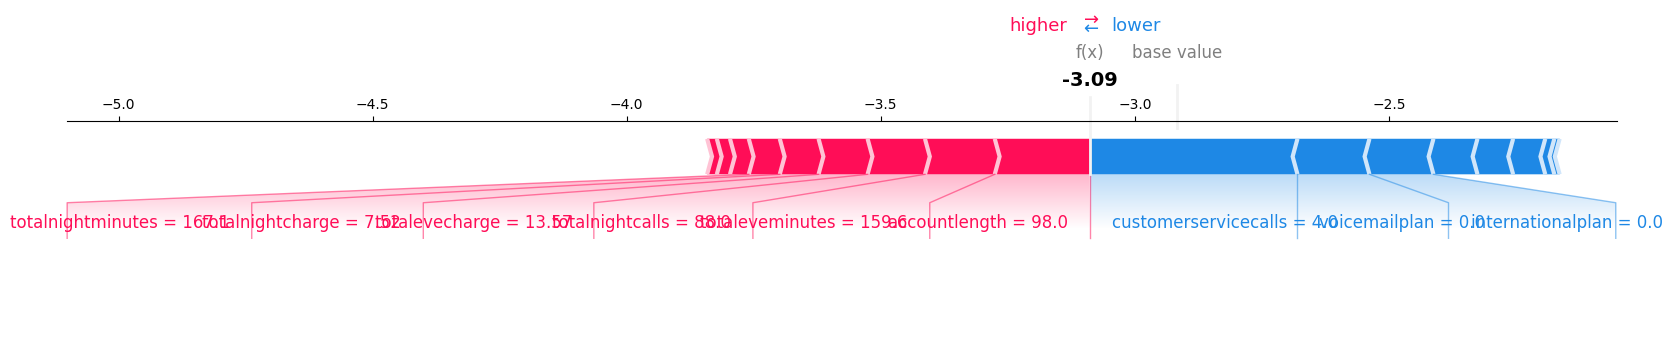

In [35]:
# SHAP
shap.initjs()

shap.force_plot(shap_explainer.expected_value, shap_values[5, :], X_test.iloc[2, :], matplotlib=True)

## Вопрос

Какой признак дает наибольший вклад в прогноз с точки зрения SHAP?

In [ ]:
# your code here

## Вопрос

Какой признак дает наибольший вклад в прогноз с точки зрения метода LIME?

## Калибровка вероятностей

Сделайте калибровку вероятностей с помощью методов 'sigmoid' и 'isotonic' при помощи CalibratedClassifierCV с `cv=2`.

Нарисуйте на одном графике исходную калибровочную кривую для CatBoost и две кривые после калибровки.

In [36]:
# your code here
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

ctb = CatBoostClassifier(verbose=0, random_state=42)

platt_ctb = CalibratedClassifierCV(ctb, cv=2, method='sigmoid')
isotonic_ctb = CalibratedClassifierCV(ctb, cv=2, method='isotonic')

clfs = [
    (ctb, 'Catboost'),
    (platt_ctb, 'Catboost + sigmoid'),
    (isotonic_ctb, 'Catboost + isotonic'),
]

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


Text(0.5, 1.0, 'Calibrations curves')

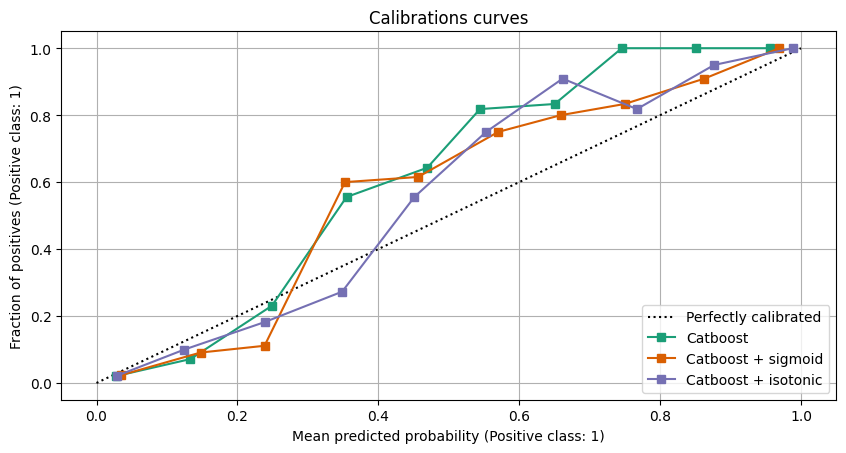

In [38]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap('Dark2')

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clfs):
  clf.fit(X_train, y_train)

  display = CalibrationDisplay.from_estimator(
      clf,
      X_test,
      y_test,
      n_bins=10,
      name=name,
      ax=ax_calibration_curve,
      color=colors(i),
  )
  calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibrations curves')

Вычислим `brier_score` до калибровки

In [39]:
from sklearn.metrics import brier_score_loss

brier_score_loss(y_test, ctb.predict_proba(X_test)[:, 1])

0.0335565178559375

## Вопрос

Вычислите `brier_score` после обеих калибровок.

В ответ запишите наименьшее из двух полученных значений, округленное до десятитысячных.

In [41]:
# your code here
sigmoid_score = brier_score_loss(y_test, platt_ctb.predict_proba(X_test)[:, 1])
isotonic_score = brier_score_loss(y_test, isotonic_ctb.predict_proba(X_test)[:, 1])
print(f'Catboost + sigmoid: {sigmoid_score}')
print(f'Catboost + isotonic: {isotonic_score}')

Catboost + sigmoid: 0.03318200504500793
Catboost + isotonic: 0.03339137327565761
